In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Sample name: Cars0.png
Sample Image Shape: <PIL.Image.Image image mode=RGB size=500x268 at 0x7AF6111A6950>
Sample Bounding Box: tensor([[226., 125., 419., 173.]])
Sample Label: ['licence']


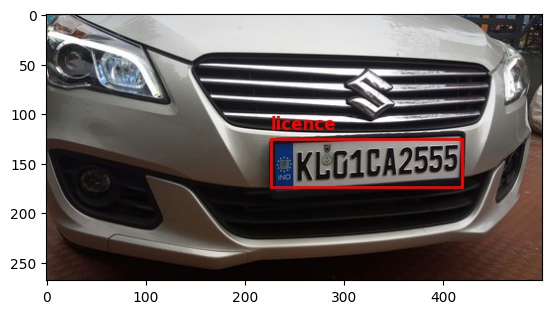

In [61]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

class CarLicensePlateDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith('.xml')]
        self.data = self._load_annotations()

    def _load_annotations(self):
        """Helper function to load all the annotations from XML files."""
        data = []

        for xml_file in self.xml_files:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            bboxes = []
            labels = []

            # Loop through each object in the XML file (multiple bounding boxes)
            for obj in root.findall('object'):
                label = obj.find('name').text  # Get label
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bboxes.append([xmin, ymin, xmax, ymax])  # Add bbox coordinates
                labels.append(label)  # Add label

            data.append({
                'filename': filename,
                'bboxes': torch.tensor(bboxes, dtype=torch.float32),
                'labels': labels,
                'size': [width, height]
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = os.path.join(self.img_dir, img_data['filename'])
        image = Image.open(img_path).convert("RGB")
        bboxes = img_data['bboxes']
        labels = img_data['labels']

        if self.transform:
            image, bboxes = self.apply_transforms(image, bboxes, img_data['size'])

        return image, bboxes, labels, img_data['filename']

    def apply_transforms(self, image, bboxes, original_size):
        """Apply transformations to the image and adjust the bounding boxes accordingly."""
        width, height = original_size

        if isinstance(self.transform, transforms.Compose):
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    new_size = t.size
                    bboxes = self.resize_bbox(bboxes, (width, height), new_size)
                elif isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < 0.5:  # Horizontal flip with 50% chance
                        image = F.hflip(image)
                        bboxes = self.flip_bbox_horizontal(bboxes, width)

        transformed_image = self.transform(image)
        return transformed_image, bboxes

    def resize_bbox(self, bboxes, original_size, new_size):
        """Resize bounding boxes according to the new image size."""
        original_w, original_h = original_size
        new_w, new_h = new_size

        scale_x = new_w / original_w
        scale_y = new_h / original_h

        bboxes[:, [0, 2]] *= scale_x  # Scale xmin and xmax
        bboxes[:, [1, 3]] *= scale_y  # Scale ymin and ymax

        return bboxes

    def flip_bbox_horizontal(self, bboxes, image_width):
        """Flip bounding boxes horizontally."""
        bboxes[:, [0, 2]] = image_width - bboxes[:, [2, 0]]  # Flip xmin and xmax
        return bboxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# Directory where XML files are stored
annotations_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/annotations'

# Directory where images are stored
img_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/images'

#Define image transformations (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()  # Convert images to tensors
])

# Create the dataset
car_dataset = CarLicensePlateDataset(annotations_dir=annotations_dir, img_dir=img_dir)


# Test loading a sample from the dataset
sample_image, sample_bbox, sample_label,sample_filename = car_dataset[0]
print("Sample name:", sample_filename)
print("Sample Image Shape:", sample_image)
print("Sample Bounding Box:", sample_bbox)
print("Sample Label:", sample_label)

# Convert the image tensor back to a NumPy array for visualization (if needed)
if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert from C x H x W to H x W x C

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample_image)



# Loop through the bounding boxes and draw each one
for bbox, label in zip(sample_bbox, sample_label):
    xmin, ymin, xmax, ymax = bbox

    # Calculate width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin



# Create a rectangle patch and add it to the axis
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, label, color='red', fontsize=12, weight='bold')

# Show the plot with the bounding box
plt.show()

In [53]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [62]:
x_min,  y_min,x_max, y_max = (bbox)
bbox= [x_min, y_min, x_max-x_min, y_max-y_min ]

In [63]:
bbox

[tensor(226.), tensor(125.), tensor(193.), tensor(48.)]

In [47]:
image = cv2.imread('/content/drive/MyDrive/project_DS/Dataset/images/Cars0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [70]:
bboxes = [bbox]
category_ids = [1]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {1: 'Plate'}

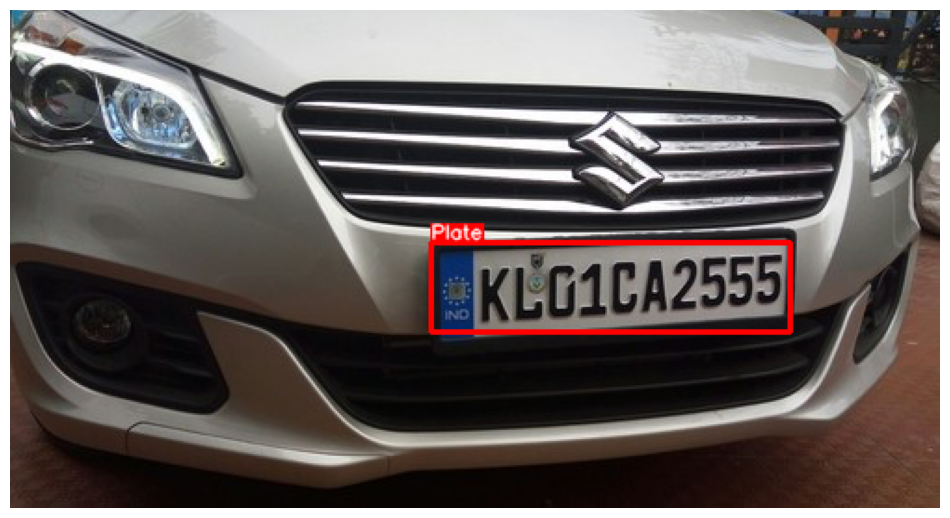

In [71]:
visualize(image, bboxes, category_ids, category_id_to_name)

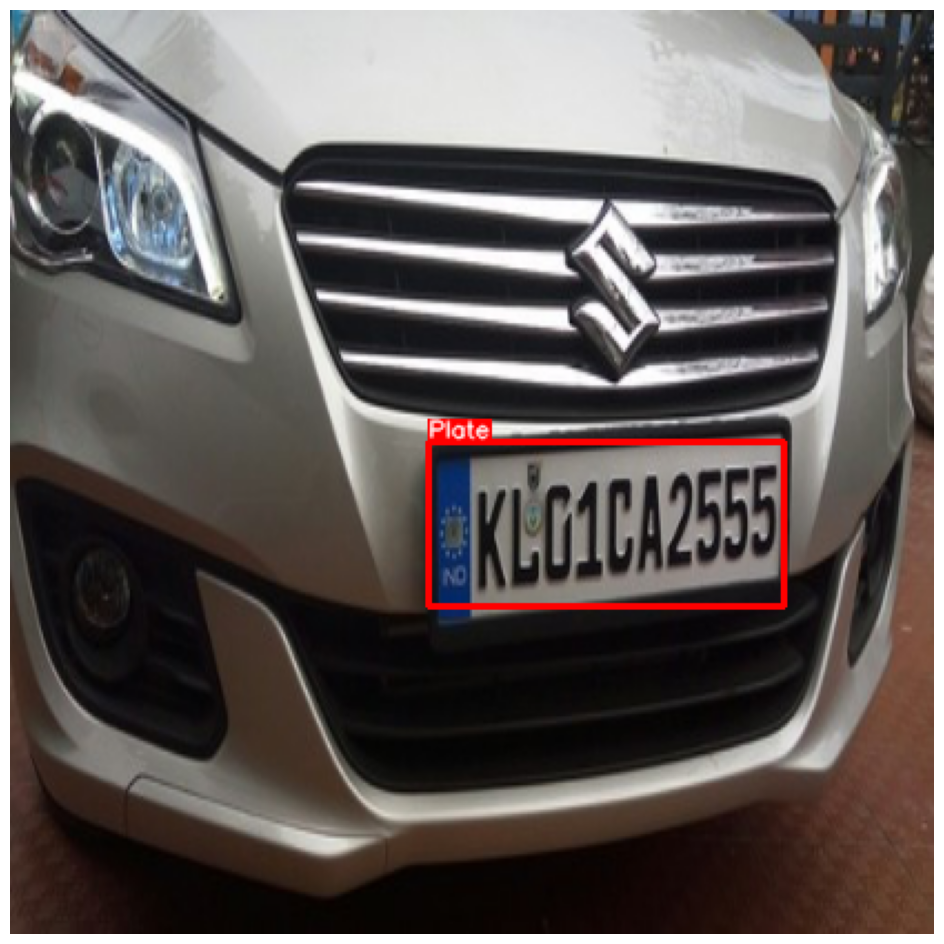

In [86]:
random.seed(7)
transform = A.Compose(
    [A.Resize(416,416)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [44]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import albumentations as A
import cv2
import numpy as np

class CarLicensePlateDataset(Dataset):
    def __init__(self, annotations_dir, img_dir):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith('.xml')]
        self.data = self._load_annotations()

        # Define albumentations transformations
        self.resize_transform = A.Compose([
            A.Resize(416, 416)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

        # Transformation for centered plates to shift them
        self.shift_transform = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.4, scale_limit=0, rotate_limit=0, p=1.0)
            ,A.RandomCrop(height=416, width=416, p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

    def _load_annotations(self):
        """Helper function to load all the annotations from XML files."""
        data = []
        for xml_file in self.xml_files:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            bboxes = []
            labels = []

            # Loop through each object in the XML file (multiple bounding boxes)
            for obj in root.findall('object'):
                label = obj.find('name').text  # Get label
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bboxes.append([xmin, ymin, xmax, ymax])  # Add bbox coordinates
                labels.append(label)  # Add label

            data.append({
                'filename': filename,
                'bboxes': np.array(bboxes, dtype=np.float32),
                'labels': labels,
                'size': [width, height]
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = os.path.join(self.img_dir, img_data['filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        bboxes = img_data['bboxes']
        labels = [1] * len(bboxes)  # Replace with integer labels if needed (e.g., 1 for license plate)

        # Resize image and bounding boxes
        transformed = self.resize_transform(image=image, bboxes=bboxes, category_ids=labels)
        resized_image = transformed['image']
        resized_bboxes = transformed['bboxes']
        resized_labels = transformed['category_ids']

        # Check if plate is centered and duplicate with shift if it is
        if self.is_plate_centered(bboxes, img_data['size']):
            augmented = self.shift_transform(image=resized_image, bboxes=resized_bboxes, category_ids=resized_labels)
            augmented_image = augmented['image']
            augmented_bboxes = augmented['bboxes']
            augmented_labels = augmented['category_ids']

            # Return both original and shifted versions
            return {
                'original_image': resized_image,
                'original_bboxes': resized_bboxes,
                'original_labels': resized_labels,
                'augmented_image': augmented_image,
                'augmented_bboxes': augmented_bboxes,
                'augmented_labels': augmented_labels
            }

        # Return only the resized version if not centered
        return {
            'image': resized_image,
            'bboxes': resized_bboxes,
            'labels': resized_labels
        }

    def is_plate_centered(self, bboxes, original_size):
        """Determine if the bounding box is centered in the original image."""
        width, height = original_size
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            bbox_center_x = (xmin + xmax) / 2
            bbox_center_y = (ymin + ymax) / 2
            if 0.4 * width < bbox_center_x < 0.6 * width and 0.4 * height < bbox_center_y < 0.6 * height:
                return True  # License plate is approximately centered
        return False


In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# Directory where XML files are stored
annotations_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/annotations'

# Directory where images are stored
img_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/images'


# Create the dataset
car_dataset = CarLicensePlateDataset(annotations_dir=annotations_dir, img_dir=img_dir)

In [87]:
def plot_augmented_images(dataset, num_images=4):
    """
    Plots only the augmented images from the dataset with their bounding boxes.

    Parameters:
    - dataset: The dataset instance (CarLicensePlateDataset).
    - num_images: Number of augmented images to display.
    """
    augmented_samples = []

    # Collect augmented samples
    for i in range(len(dataset)):
        sample = dataset[i]
        if 'augmented_image' in sample:
            augmented_samples.append(sample)
        if len(augmented_samples) >= num_images:
            break

    # Set up the plot grid
    fig, axes = plt.subplots(len(augmented_samples), 2, figsize=(12, len(augmented_samples) * 5))
    for i, sample in enumerate(augmented_samples):
        # Plot original image with bounding boxes
        plot_image_with_bboxes(axes[i, 0], sample['original_image'], sample['original_bboxes'], title="Original Image")
        plot_image_with_bboxes(axes[i, 1], sample['augmented_image'], sample['augmented_bboxes'], title="Augmented Image")

    plt.tight_layout()
    plt.show()

# Example usage
plot_augmented_images(car_dataset, num_images=4)


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

<ipython-input-47-8bdd54cd2d74>:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5, cbar=True)


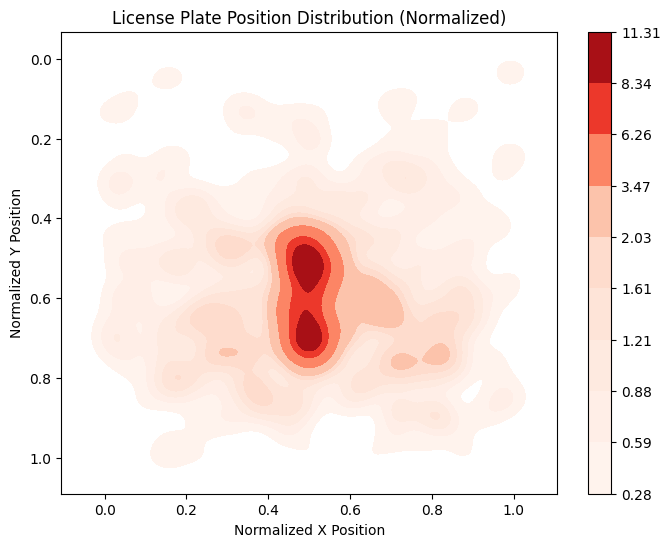

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_license_plate_position_distribution(dataset):
    """
    Plots the distribution of license plate positions across the dataset,
    including both original and augmented images if available.

    Parameters:
    - dataset: The dataset instance (CarLicensePlateDataset).
    """
    x_centers = []
    y_centers = []

    for sample in dataset:
        # Handle both original and augmented data
        if 'augmented_image' in sample:
            # Process original image
            original_image = sample['original_image']
            original_bboxes = sample['original_bboxes']
            width, height = original_image.shape[1], original_image.shape[0]  # Get width and height

            for bbox in original_bboxes:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)  # Normalize x position
                y_centers.append(y_center / height)  # Normalize y position

            # Process augmented (shifted) image
            augmented_image = sample['augmented_image']
            augmented_bboxes = sample['augmented_bboxes']
            width, height = augmented_image.shape[1], augmented_image.shape[0]

            for bbox in augmented_bboxes:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)  # Normalize x position
                y_centers.append(y_center / height)  # Normalize y position
        else:
            # Process non-augmented image
            image = sample['image']
            bboxes = sample['bboxes']
            width, height = image.shape[1], image.shape[0]

            for bbox in bboxes:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)  # Normalize x position
                y_centers.append(y_center / height)  # Normalize y position

    # Plot the heatmap of license plate positions
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5, cbar=True)
    plt.title('License Plate Position Distribution (Normalized)')
    plt.xlabel('Normalized X Position')
    plt.ylabel('Normalized Y Position')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
    plt.show()

# Example usage
plot_license_plate_position_distribution(car_dataset)


In [48]:
len(list(car_dataset))

433

In [121]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import albumentations as A
import cv2
import numpy as np

class CarLicensePlateDataset(Dataset):
    def __init__(self, annotations_dir, img_dir):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith('.xml')]
        self.data = self._load_annotations()

        # Define albumentations transformations
        self.resize_transform = A.Compose([
            A.Resize(416, 416)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

        # Two shift transformations with slightly different settings
        self.shift_transform_1 = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.4, scale_limit=0, rotate_limit=5, p=1.0),
            A.RandomCrop(height=416, width=416, p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

        self.shift_transform_2 = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.4, scale_limit=0, rotate_limit=5, p=1.0),
            A.RandomCrop(height=416, width=416, p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

    def _load_annotations(self):
        """Helper function to load all the annotations from XML files."""
        data = []
        for xml_file in self.xml_files:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            filename = root.find('filename').text
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            bboxes = []
            labels = []

            # Loop through each object in the XML file (multiple bounding boxes)
            for obj in root.findall('object'):
                label = obj.find('name').text  # Get label
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bboxes.append([xmin, ymin, xmax, ymax])  # Add bbox coordinates
                labels.append(label)  # Add label

            data.append({
                'filename': filename,
                'bboxes': np.array(bboxes, dtype=np.float32),
                'labels': labels,
                'size': [width, height]
            })

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      img_data = self.data[idx]
      img_path = os.path.join(self.img_dir, img_data['filename'])
      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
      bboxes = img_data['bboxes']
      labels = [1] * len(bboxes)  # Replace with integer labels if needed (e.g., 1 for license plate)

    # Resize image and bounding boxes
      transformed = self.resize_transform(image=image, bboxes=bboxes, category_ids=labels)
      resized_image = transformed['image']
      resized_bboxes = transformed['bboxes']
      resized_labels = transformed['category_ids']

    # Check if plate is centered and create two shifted duplicates if it is
      if self.is_plate_centered(bboxes, img_data['size']):
        augmented_1 = self.shift_transform_1(image=resized_image, bboxes=resized_bboxes, category_ids=resized_labels)
        augmented_2 = self.shift_transform_2(image=resized_image, bboxes=resized_bboxes, category_ids=resized_labels)

        # Return both original and shifted versions, with filename
        return {
            'filename': img_data['filename'],  # Add filename here
            'original_image': resized_image,
            'original_bboxes': resized_bboxes,
            'original_labels': resized_labels,
            'augmented_image_1': augmented_1['image'],
            'augmented_bboxes_1': augmented_1['bboxes'],
            'augmented_labels_1': augmented_1['category_ids'],
            'augmented_image_2': augmented_2['image'],
            'augmented_bboxes_2': augmented_2['bboxes'],
            'augmented_labels_2': augmented_2['category_ids']
        }

    # Return only the resized version if not centered, with filename
      return {
        'filename': img_data['filename'],  # Add filename here
        'image': resized_image,
        'bboxes': resized_bboxes,
        'labels': resized_labels
    }


    def is_plate_centered(self, bboxes, original_size):
        """Determine if the bounding box is centered in the original image."""
        width, height = original_size
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            bbox_center_x = (xmin + xmax) / 2
            bbox_center_y = (ymin + ymax) / 2
            if 0.35 * width < bbox_center_x < 0.65 * width and 0.35 * height < bbox_center_y < 0.65 * height:
                return True  # License plate is approximately centered
        return False


In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# Directory where XML files are stored
annotations_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/annotations'

# Directory where images are stored
img_dir = '/content/drive/My Drive/project_DS/data_set_a/archive/images'


# Create the dataset
car_dataset = CarLicensePlateDataset(annotations_dir=annotations_dir, img_dir=img_dir)

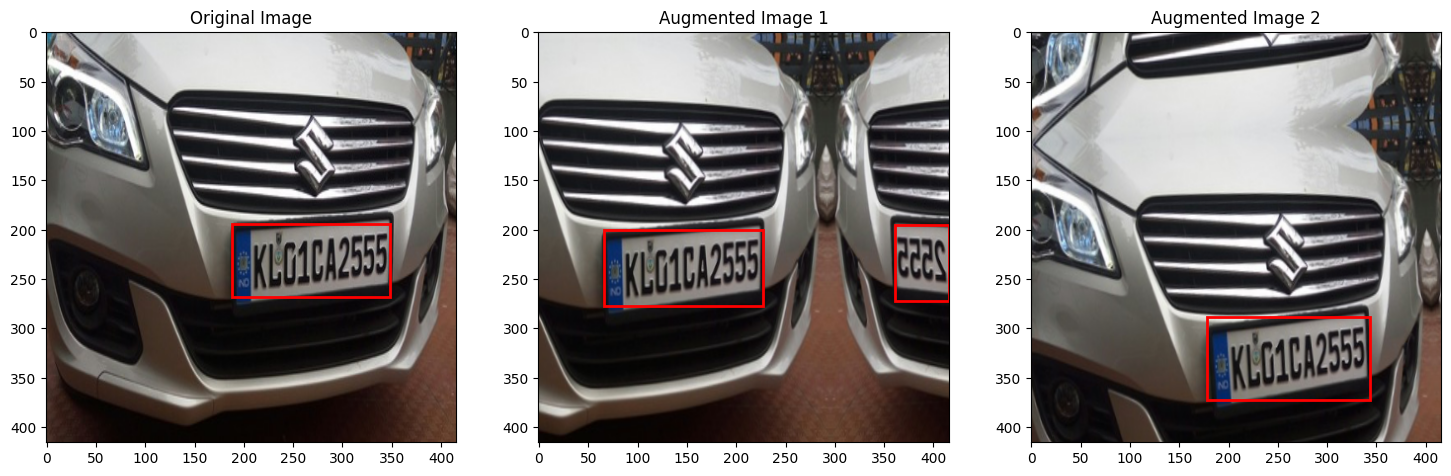

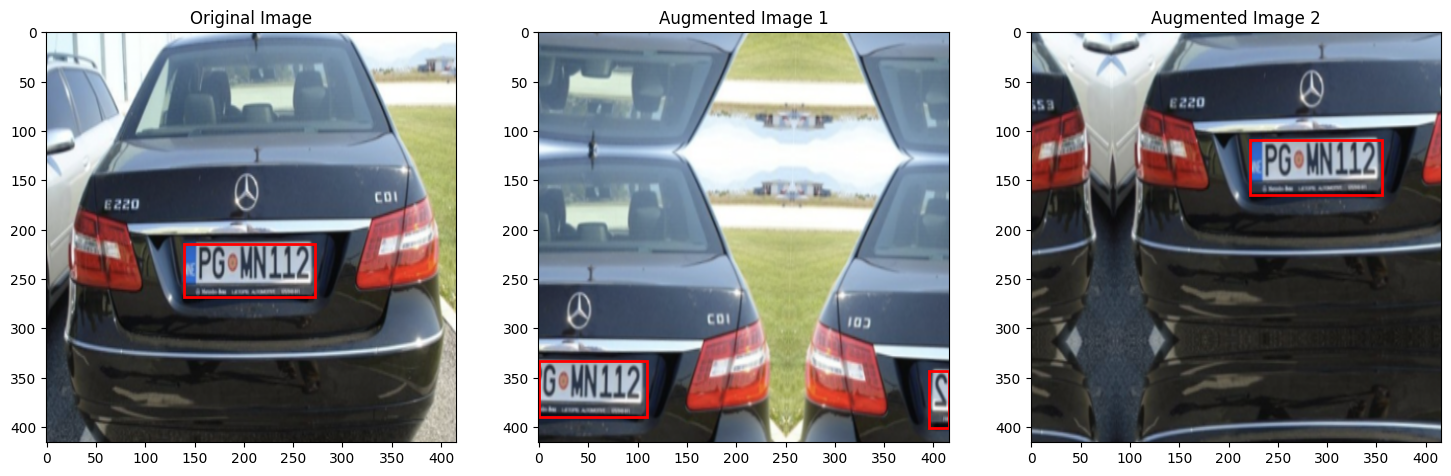

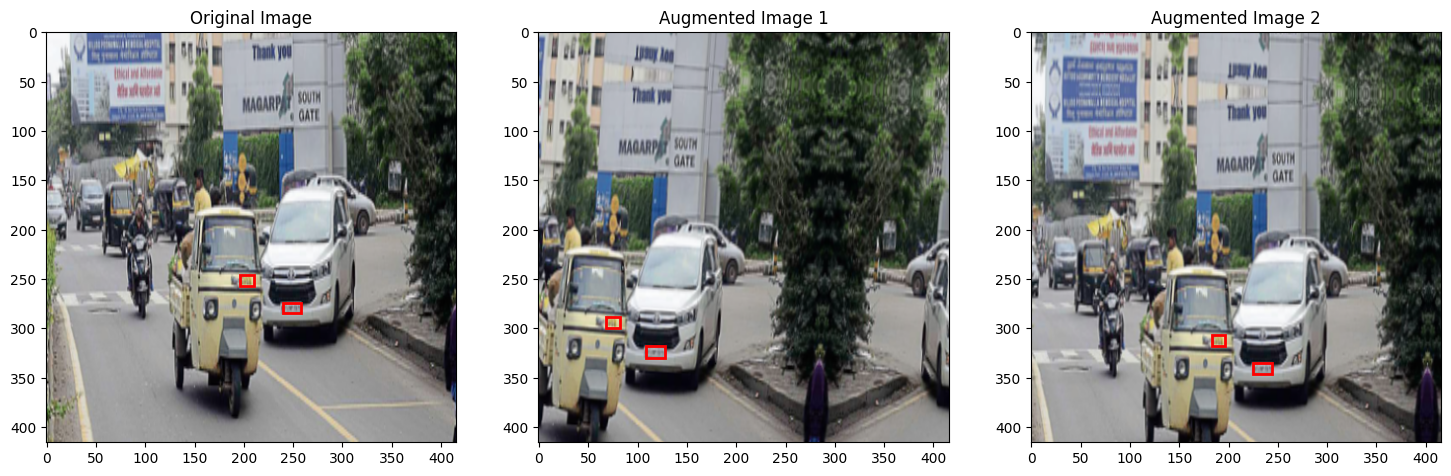

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_augmented_sample(sample):
    """
    Plots original and two augmented versions of an image with bounding boxes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original image
    axes[0].imshow(sample['original_image'])
    axes[0].set_title("Original Image")
    for bbox in sample['original_bboxes']:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)

    # Plot augmented image 1
    axes[1].imshow(sample['augmented_image_1'])
    axes[1].set_title("Augmented Image 1")
    for bbox in sample['augmented_bboxes_1']:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)

    # Plot augmented image 2
    axes[2].imshow(sample['augmented_image_2'])
    axes[2].set_title("Augmented Image 2")
    for bbox in sample['augmented_bboxes_2']:
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        axes[2].add_patch(rect)

    plt.show()

# Display a few augmented samples from the dataset
num_samples = 3  # Number of samples to display
samples_plotted = 0

for i in range(len(car_dataset)):
    sample = car_dataset[i]
    if 'augmented_image_1' in sample and 'augmented_image_2' in sample:
        plot_augmented_sample(sample)
        samples_plotted += 1
    if samples_plotted >= num_samples:
        break


<ipython-input-124-620c6bebf9e9>:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5, cbar=True)


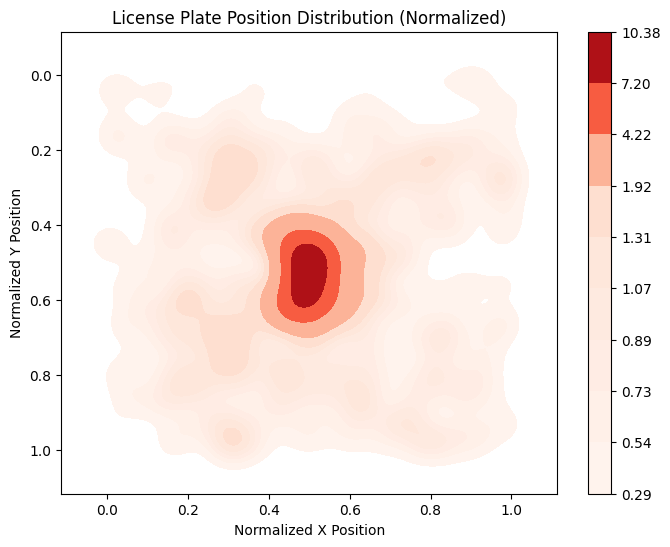

In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_normalized_position_distribution(dataset):
    """
    Plots the distribution of normalized license plate positions across the dataset,
    including both original and augmented images if available.

    Parameters:
    - dataset: The dataset instance (CarLicensePlateDataset).
    """
    x_centers = []
    y_centers = []

    for sample in dataset:
        # Process original image
        if 'original_image' in sample:
            original_image = sample['original_image']
            original_bboxes = sample['original_bboxes']
            width, height = original_image.shape[1], original_image.shape[0]  # Get width and height

            for bbox in original_bboxes:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)  # Normalize x position
                y_centers.append(y_center / height)  # Normalize y position

        # Process augmented image 1
        if 'augmented_image_1' in sample:
            augmented_image_1 = sample['augmented_image_1']
            augmented_bboxes_1 = sample['augmented_bboxes_1']
            width, height = augmented_image_1.shape[1], augmented_image_1.shape[0]

            for bbox in augmented_bboxes_1:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)
                y_centers.append(y_center / height)

        # Process augmented image 2
        if 'augmented_image_2' in sample:
            augmented_image_2 = sample['augmented_image_2']
            augmented_bboxes_2 = sample['augmented_bboxes_2']
            width, height = augmented_image_2.shape[1], augmented_image_2.shape[0]

            for bbox in augmented_bboxes_2:
                xmin, ymin, xmax, ymax = bbox
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2
                x_centers.append(x_center / width)
                y_centers.append(y_center / height)

    # Plot the heatmap of license plate positions
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=x_centers, y=y_centers, cmap='Reds', shade=True, bw_adjust=0.5, cbar=True)
    plt.title('License Plate Position Distribution (Normalized)')
    plt.xlabel('Normalized X Position')
    plt.ylabel('Normalized Y Position')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
    plt.show()

# Example usage
plot_normalized_position_distribution(car_dataset)


In [131]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

def save_dataset_with_augmentations(dataset, output_img_dir, output_ann_dir, image_extension=".png"):
    """
    Saves the original and augmented images with updated annotation files.

    Parameters:
    - dataset: The dataset instance (CarLicensePlateDataset).
    - output_img_dir: Directory to save output images.
    - output_ann_dir: Directory to save updated annotation files.
    - image_extension: Desired file extension for saved images (e.g., ".jpg", ".png").
    """
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)

    for i, sample in enumerate(dataset):
        # Get filename base (without extension) from sample
        base_filename = os.path.splitext(sample['filename'])[0]

        # Save original image and annotation
        if 'original_image' in sample:
            original_image = sample['original_image']
            original_bboxes = sample['original_bboxes']
            original_filepath = os.path.join(output_img_dir, f"{base_filename}{image_extension}")
            Image.fromarray(original_image).save(original_filepath)

            # Save the original annotation file with the original bounding boxes
            original_ann_filepath = os.path.join(output_ann_dir, f"{base_filename}.xml")
            save_annotation_file(base_filename, original_bboxes, original_ann_filepath, dataset.annotations_dir)

        # Save augmented images and annotations, if available
        if 'augmented_image_1' in sample:
            # Augmentation 1
            aug1_image = sample['augmented_image_1']
            aug1_bboxes = sample['augmented_bboxes_1']
            aug1_filepath = os.path.join(output_img_dir, f"{base_filename}_aug1{image_extension}")
            Image.fromarray(aug1_image).save(aug1_filepath)

            aug1_ann_filepath = os.path.join(output_ann_dir, f"{base_filename}_aug1.xml")
            save_annotation_file(base_filename, aug1_bboxes, aug1_ann_filepath, dataset.annotations_dir)

        if 'augmented_image_2' in sample:
            # Augmentation 2
            aug2_image = sample['augmented_image_2']
            aug2_bboxes = sample['augmented_bboxes_2']
            aug2_filepath = os.path.join(output_img_dir, f"{base_filename}_aug2{image_extension}")
            Image.fromarray(aug2_image).save(aug2_filepath)

            aug2_ann_filepath = os.path.join(output_ann_dir, f"{base_filename}_aug2.xml")
            save_annotation_file(base_filename, aug2_bboxes, aug2_ann_filepath, dataset.annotations_dir)

def save_annotation_file(filename_base, bboxes, output_filepath, annotations_dir):
    """
    Saves a modified annotation XML file with updated bounding boxes.

    Parameters:
    - filename_base: The base filename (without extension).
    - bboxes: List of bounding boxes for the image in format [xmin, ymin, xmax, ymax].
    - output_filepath: Path to save the modified annotation XML file.
    - annotations_dir: Directory of the original annotation XML files.
    """
    # Construct the correct path for the original annotation XML file
    original_ann_path = os.path.join(annotations_dir, f"{filename_base}.xml")
    if not os.path.exists(original_ann_path):
        raise FileNotFoundError(f"Annotation file not found: {original_ann_path}")

    # Load and modify the XML file
    tree = ET.parse(original_ann_path)
    root = tree.getroot()

    # Update bounding boxes in XML
    for obj, bbox in zip(root.findall('object'), bboxes):
        xmin, ymin, xmax, ymax = bbox
        bndbox = obj.find('bndbox')
        bndbox.find('xmin').text = str(int(xmin))
        bndbox.find('ymin').text = str(int(ymin))
        bndbox.find('xmax').text = str(int(xmax))
        bndbox.find('ymax').text = str(int(ymax))

    # Save the updated annotation XML file
    tree.write(output_filepath)

# Example usage
output_img_dir = 'output_images'
output_ann_dir = 'output_annotations'
annotations_dir = '/path/to/annotations_dir'  # Specify the correct path to annotations
save_dataset_with_augmentations(car_dataset, output_img_dir, output_ann_dir, image_extension=".jpg")


In [135]:
import zipfile
import os

# Paths to the directories and zip file
output_img_dir = 'output_images'
output_ann_dir = 'output_annotations'
zip_filename = 'augmented_dataset.zip'

# Create a zip file that contains both the images and annotations in separate folders
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add all files from the output_img_dir to an "images" folder in the zip
    for root, dirs, files in os.walk(output_img_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.join('images', os.path.relpath(file_path, start=output_img_dir)))

    # Add all files from the output_ann_dir to an "annotations" folder in the zip
    for root, dirs, files in os.walk(output_ann_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.join('annotations', os.path.relpath(file_path, start=output_ann_dir)))

# If running in Google Colab, download the zip file directly
from google.colab import files
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
import os

# Directories for images and annotations
output_img_dir = 'output_images'
output_ann_dir = 'output_annotations'

# Get lists of image and annotation files (without extensions)
image_files = {os.path.splitext(f)[0] for f in os.listdir(output_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))}
annotation_files = {os.path.splitext(f)[0] for f in os.listdir(output_ann_dir) if f.endswith('.xml')}

# Find images without corresponding annotations
missing_annotations = image_files - annotation_files

# Print the unmatched images
if missing_annotations:
    print("Images without corresponding annotations:")
    for img in missing_annotations:
        print(img)
else:
    print("All images have corresponding annotations.")


All images have corresponding annotations.
